In [1]:
# importing some useful libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import pickle
import time

import seaborn as sns
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud

## Data Inspection and Cleaning

In [2]:
df = pd.read_csv("./data/phishing_site_urls.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [4]:
df = df.astype({"Label": "category"})

In [5]:
# remove the query part of the URL i.e part after '?'
df["URL"] = df["URL"].apply(lambda x: x.split("?")[0])

In [6]:
df.head(10)

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
5,smilesvoegol.servebbs.org/voegol.php,bad
6,premierpaymentprocessing.com/includes/boleto-2...,bad
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad
8,super1000.info/docs,bad
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad


In [7]:
df.describe()

,URL,Label
count,549346,549346
unique,461400,2
top,youtube.com/watch,good
freq,8543,392924


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   URL     549346 non-null  object  
 1   Label   549346 non-null  category
dtypes: category(1), object(1)
memory usage: 4.7+ MB


In [9]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

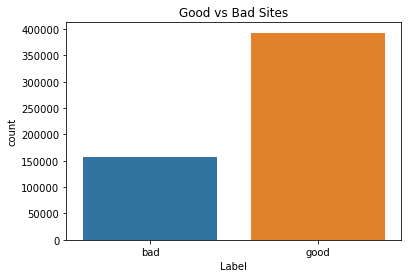

In [10]:
sns.countplot(x="Label", data=df)
plt.title("Good vs Bad Sites")
plt.show()

## Main

In [11]:
tokenizer = RegexpTokenizer(r"[A-Za-z]+")

In [12]:
tokenizer.tokenize(df.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php']

In [13]:
print("Getting words tokenized ...")
t0 = time.perf_counter()
df["text_tokenized"] = df.URL.map(lambda t: tokenizer.tokenize(t))
t1 = time.perf_counter() - t0
print("Time taken", t1, "sec")

Getting words tokenized ...
Time taken 3.2990494999999953 sec


In [14]:
df.head()

,URL,Label,text_tokenized
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int..."
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi..."


In [15]:
stemmer = SnowballStemmer("english")

In [16]:
print("Getting words stemmed ...")
t0 = time.perf_counter()
df["text_stemmed"] = df["text_tokenized"].map(
    lambda l: [stemmer.stem(word) for word in l]
)
t1 = time.perf_counter() - t0
print("Time taken", t1, "sec")

Getting words stemmed ...
Time taken 40.244719200000006 sec


In [17]:
df.head()

,URL,Label,text_tokenized,text_stemmed
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into..."
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide..."


In [18]:
print("Get joiningwords ...")
t0 = time.perf_counter()
df["text_sent"] = df["text_stemmed"].map(lambda l: " ".join(l))
t1 = time.perf_counter() - t0
print("Time taken", t1, "sec")

Get joiningwords ...
Time taken 0.25507310000000416 sec


In [19]:
bad_sites = df[df.Label == "bad"]
good_sites = df[df.Label == "good"]

In [20]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [21]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm,good,"[esxcc, com, js, index, htm]","[esxcc, com, js, index, htm]",esxcc com js index htm
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


In [22]:
df.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


## Model

In [23]:
cv = CountVectorizer()

In [24]:
feature = cv.fit_transform(df.text_sent)

In [25]:
feature[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [26]:
pipeline_ls = make_pipeline(
    CountVectorizer(
        tokenizer=RegexpTokenizer(r"[A-Za-z]+").tokenize, stop_words="english"
    ),
    LogisticRegression(),
)

In [27]:
trainX, testX, trainY, testY = train_test_split(df.URL, df.Label)

In [28]:
pipeline_ls.fit(trainX, trainY)

c:\Users\siddh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

Training Accuracy : 0.9777286418500567
Testing Accuracy : 0.9644596867559361

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.96      0.94     36685
        Good       0.99      0.96      0.98    100652

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.96    137337
weighted avg       0.97      0.96      0.96    137337


CONFUSION MATRIX


<AxesSubplot:>

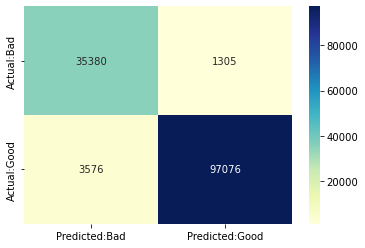

In [29]:
print("Training Accuracy :", pipeline_ls.score(trainX, trainY))
print("Testing Accuracy :", pipeline_ls.score(testX, testY))
con_mat = pd.DataFrame(
    confusion_matrix(pipeline_ls.predict(testX), testY),
    columns=["Predicted:Bad", "Predicted:Good"],
    index=["Actual:Bad", "Actual:Good"],
)


print("\nCLASSIFICATION REPORT\n")
print(
    classification_report(
        pipeline_ls.predict(testX), testY, target_names=["Bad", "Good"]
    )
)

print("\nCONFUSION MATRIX")
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt="d", cmap="YlGnBu")

In [30]:
# Save the model
with open("./model.pkl", "wb") as f:
    pickle.dump(pipeline_ls, f)